# Praxisbeispiel Katzen vs. Hunde
In diesem Jupiternotebook wird Schritt für Schritt erläutert, wie man mithilfe von Tensorflow,
Neuronale Netzwerke erstellt, trainiert und bewertet sowie Daten lädt und für das Training vorbereitet.

## I. Import der notwendigen Module


- ``tensorflow`` und ``keras`` für das Neuronale Netzwerk
- ``Matplolib`` für das Anzeigen von Bildern und Grafiken

In [6]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline 
from typing import List
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
import os

ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator

## II. Laden und Untersuchen des Datensatzes
- Dieser beinhaltet ``Bilder`` von ``Hunden`` und ``Katzen``
- Zu jedem Bild gibt es ein ``Label`` das angibt welches der beiden Tiere auf dem Bild zu sehen ist.
- ``0`` steht dabei für eine Katze
- ``1`` steht für einen Hund

Metadaten:
- Insgesamt 25000
- 12.500 Bilder von Katzen
- 12.500 Bilder von Hunden

- Bilder haben 3 Farbchannels (RGB)

In [35]:
os.chdir(r'C:\Users\nic-e\Datasets\PetImages')

img_generator = ImageDataGenerator(
    rescale = 1/255., 
    horizontal_flip = True, 
    zoom_range = 0.3, 
    rotation_range = 15.,
    validation_split = 0.2,
)
batch_size = 30
height, width = (256,256)

train_dataset = img_generator.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('Dog','Cat'),
    batch_size = batch_size,
    subset = 'training'
)

val_dataset = img_generator.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('Dog','Cat'),
    batch_size = batch_size,
    subset = 'validation'
)


Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


### II.I Untersuchen der Daten

Bevor die Daten zum trainieren verwendet werden, ist es hilfreich diese zu untersuchen.

Dabei gilt es unter anderem folgendes festzustellen:

1. Wie viele Trainingsdaten gibt es
2. Wie sind die Daten verteilt (ist eine Klasse deutlich größer als die andere(n))
3. Sind die Label vollständig und richtig gesetzt

#### Anzahl der Trainingsdaten


In [71]:
print(f'Die Menge aller Daten enthält:              {len(train_dataset) + len(test_dataset)}    Samples')
print(f'Die Menge aller Trainingsdaten enthält:     {len(train_dataset)}    Samples')
print(f'Die Menge aller Testdaten enthält:          {len(test_dataset)}     Samples')

Die Menge aller Daten enthält:              23262    Samples
Die Menge aller Trainingsdaten enthält:     16283    Samples
Die Menge aller Testdaten enthält:          6979     Samples


#### Verteilung der Daten

In [88]:
def count(data) -> List[int]:
    number_of_dogs: int = sum([sample[1].numpy() for sample in data])
    number_of_cats: int = len(data) - number_of_dogs

    return number_of_cats, number_of_dogs

# count cats and dogs in training and test dataset
train_cats, train_dogs = count(train_dataset)
test_cats, test_dogs = count(test_dataset)

print(f'Der Trainingsdatenstz besteht aus:  {train_cats}    Katzenbildern und   {train_dogs}    Hundebildern')
print(f'Der Testdatensatz besteht aus:      {test_cats}    Katzenbildern und   {test_dogs}    Hundebildern')



ValueError: operands could not be broadcast together with shapes (32,) (27,) 

#### Visualisierung der Daten

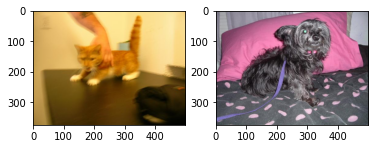

In [100]:

plt.subplot(1,2,1)
plt.imshow(img.imread('Cat/0.jpg'))
plt.subplot(1,2,2)
plt.imshow(img.imread('Dog/0.jpg'))


### Data Preprocessing
- Die Bilder Brauchen eine einheitliche Größe, damit das Neuronale Netzwerk darauf konfiguriert werden kann.

Hierfür definieren wir ein Funktion die über die Daten iteriert und alle bilder auf die Gleiche `Höhe` und `Breite` skaliert.

Des weiteren werden die Bilder in Gruppen von jeweils 32 Bildern zusammengefasst. Diese Gruppen nennt man einen ``batch``.

<img src="./images/Batch.png" alt="Alt text that describes the graphic" title="Title text" style="width:900px;height:450px" />

Dies ist von Vorteil, da hier nicht nach jedem Bild Backpropagation angewendet wird, sondern erst nach ausrechnen eines gesamten Batches. Dies Beschläuning das Traning um ein vielfaches und kann auch positiv für die Generalisierung des neuronales Netzwerkes sein.

In [74]:
HEIGHT: int = 400 # pixel
WIDTH: int = 400 # pixel

def preprocess(img, label):
    return tf.image.resize(img, [HEIGHT, WIDTH]), label

train_dataset = train_dataset.map(preprocess).batch(32)
test_dataset = test_dataset.map(preprocess).batch(32)

In [76]:
# inspect the shape of the dataset
for batch in test_dataset.take(1): print(batch)

(<tf.Tensor: shape=(32, 400, 400, 3), dtype=float32, numpy=
array([[[[199.375   , 176.375   , 192.375   ],
         [136.125   , 113.125   , 129.125   ],
         [141.75    , 118.75    , 134.75    ],
         ...,
         [204.5     , 223.5     , 239.75    ],
         [202.      , 221.      , 236.      ],
         [206.375   , 225.375   , 240.375   ]],

        [[130.69296 , 107.69297 , 123.69297 ],
         [ 61.935944,  38.935944,  54.935944],
         [ 62.36563 ,  39.36563 ,  55.36563 ],
         ...,
         [185.69296 , 204.69296 , 221.5664  ],
         [184.23203 , 203.23203 , 219.89453 ],
         [189.64609 , 208.64609 , 225.3086  ]],

        [[126.99219 , 103.99219 , 119.99219 ],
         [ 51.45703 ,  28.457031,  44.45703 ],
         [ 47.23828 ,  24.238281,  40.23828 ],
         ...,
         [176.39453 , 193.50781 , 214.01172 ],
         [176.49219 , 194.05469 , 213.21094 ],
         [183.28516 , 200.84766 , 220.0039  ]],

        ...,

        [[255.      , 254.      

In [ ]:
classNames = ['cat', 'dog']

# define and move to dataset directory
os.chdir(r'C:\Users\nic-e\Datasets\PetImages')

images = []
for i in range(10):
  im = img.imread('Cat/{}.jpg'.format(i))
  images.append(im)
  print('image shape', im.shape, 'maximum color level', im.max())


## Erstellen des Neuronalen Netzwerks

#### Dense Layer
<img src="./images/Dense_Layer.png" alt="Alt text that describes the graphic" title="Title text" style="width:600px;height:300px" />

#### Convolutional Layer
<img src="./images/Convolutional_Layer.png" alt="Alt text that describes the graphic" title="Title text" style="width:900px;height:450px" />

#### Kernel
<img src="./images/ConvolutionII.png" alt="Alt text that describes the graphic" title="Title text" />

#### Max Pooling Layer
<img src="./images/MaxPoolingLayer.png" alt="Alt text that describes the graphic" title="Title text" />



In [49]:
def get_model():
    model = keras.models.Sequential()

    initializers = {
        
    }
    model.add( 
        keras.layers.Conv2D(
            24, 5, input_shape=(256,256,3), 
            activation='relu', 
        )
    )
    model.add(MaxPooling2D(2))
    model.add(Conv2D(48, 5, activation='relu', ))
    model.add(MaxPooling2D(2) )
    model.add(Conv2D(96, 5, activation='relu', ))
    model.add( keras.layers.Flatten() )
    model.add( keras.layers.Dropout(0.9) )
    model.add( keras.layers.Dense(2, activation='softmax', ))

    # Print a summary of the model and compile it
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adamax(lr=0.001), metrics=['acc'])    
    return model

# Trainieren des Models

- das Modell wird trainiert und die Trainingshistorie wird gespeichert

In [50]:
model = get_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 252, 252, 24)      1824      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 126, 126, 24)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 122, 122, 48)      28848     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 61, 61, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 57, 57, 96)        115296    
                                                                 
 flatten_7 (Flatten)         (None, 311904)           

In [51]:
history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=24,
    epochs=20,
)

C:\Users\nic-e\AppData\Local\Temp/ipykernel_27316/2405436493.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
667/667 [==============================] - 39s 57ms/step - loss: 0.6451 - acc: 0.6237 - val_loss: 0.5604 - val_acc: 0.7179
Epoch 2/20
667/667 [==============================] - 39s 58ms/step - loss: 0.5697 - acc: 0.7025 - val_loss: 0.5389 - val_acc: 0.7211
Epoch 3/20
667/667 [==============================] - 38s 57ms/step - loss: 0.5406 - acc: 0.7340 - val_loss: 0.5084 - val_acc: 0.7483
Epoch 4/20
667/667 [==============================] - 38s 56ms/step - loss: 0.5051 - acc: 0.7549 - val_loss: 0.4770 - val_acc: 0.7733
Epoch 5/20
667/667 [==============================] - 37s 55ms/step - loss: 0.4835 - acc: 0.7699 - val_loss: 0.4397 - val_acc: 0.7961
Epoch 6/20
667/667 [==============================] - 38s 56ms/step - loss: 0.4535 - acc: 0.7875 - val_loss: 0.4727 - val_acc: 0.7795
Epoch 7/20
667/667 [==============================] - 37s 55ms/step - loss: 0.4438 - acc: 0.7966 - val_loss: 0.4252 - val_acc: 0.8141
Epoch 8/20
667/667 [==============================] - 37s 55ms

# Trainigshistorie

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


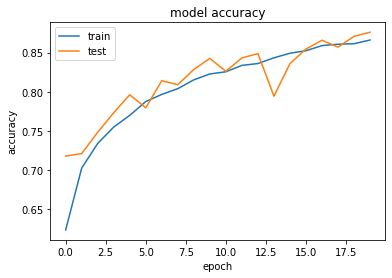

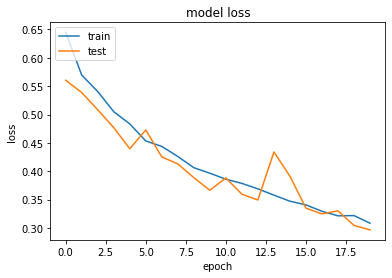

In [52]:

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:

from PIL import Image
dir = os.listdir('./Cat')
for i in dir:
  m = Image.open(f'Cat/{i}')
  m.load()
  print(i)

0.jpg
1.jpg
10.jpg
100.jpg
1000.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg
10009.jpg
1001.jpg
10010.jpg
10011.jpg
10012.jpg
10013.jpg
10014.jpg
10015.jpg
10016.jpg
10017.jpg
10018.jpg
10019.jpg
1002.jpg
10020.jpg
10021.jpg
10022.jpg
10023.jpg
10024.jpg
10025.jpg
10026.jpg
10027.jpg
10028.jpg
10029.jpg
1003.jpg
10030.jpg
10031.jpg
10032.jpg
10033.jpg
10034.jpg
10035.jpg
10036.jpg
10037.jpg
10038.jpg
10039.jpg
1004.jpg
10040.jpg
10041.jpg
10042.jpg
10043.jpg
10044.jpg
10045.jpg
10046.jpg
10047.jpg
10048.jpg
10049.jpg
1005.jpg
10050.jpg
10051.jpg
10052.jpg
10053.jpg
10054.jpg
10055.jpg
10056.jpg
10057.jpg
10058.jpg
10059.jpg
1006.jpg
10060.jpg
10061.jpg
10062.jpg
10063.jpg
10064.jpg
10065.jpg
10066.jpg
10067.jpg
10068.jpg
10069.jpg
1007.jpg
10070.jpg
10071.jpg
10072.jpg
10073.jpg
10074.jpg
10075.jpg
10076.jpg
10077.jpg
10078.jpg
10079.jpg
1008.jpg
10080.jpg
10081.jpg
10082.jpg
10083.jpg
10084.jpg
10085.jpg
10086.jpg
10087.jpg
10088.jpg
10